### Week 4 Assignment Tasks
*  description of the problem and a discussion of the background. (15 marks)
* A description of the data and how it will be used to solve the problem. (15 marks)

<div id="the_battle_of_neighborhoods">
    <h1>The Battle of Neighborhoods</h1>
</div>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#introduction">Introduction/Business Problem</a></li>
        <ol>
            <li><a href="#problem">Problem</a></li>
            <li><a href="#similarity">Similarity</a></li>
        </ol>
        <li><a href="#data_collection">Data Collection and Data Wrangling</a></li>
        <ol>
            <li><a href="#ny_data">New York Data</a></li>
            <li><a href="#toronto_data">Toronto Data</a></li>
        </ol>
        <li><a href="#data_analysis">Data Analysis</a></li>
        <ol>
            <li><a href="#common_venues">Finding common venues in New York and Toronto</a></li>
            <li><a href="#analyze_ny">Analyze New York Data</a></li>
            <li><a href="#analyze_toronto">Analyze Toronto Data</a></li>
        </ol>
        <li><a href="#similar_neighborhood">Finding Similar Neighborhood</a></li>
        <ol>
            <li><a href="#matrix_multiplication">Matrix Multiplication</a></li>
            <li><a href="#validate_matched">Validate Matched Locations</a></li>
        </ol>
    </ol>
</div>
<br>
<hr>


<div id="introduction">
    <h2>1. Introduction/Business Problem</h2>
</div>
<div id="problem">
    <h3>a. Problem</h3>
</div>
<div>
Many people constantly seek new job opportunities within the same community they live in or across the city or even a different city itself. Let's say a person got an interesting job offer from a different city , say New York and he/she lives in Downtown Toronto currently. It would be really helpful to seek a place to live which is most similar to the current living location of that person. 
<p>Some of the popular location categories one might look for in the proximity of a living area are grocery stores, colleges or/and schools, parks, restaurants, coffee-shops, hospitals and other community areas like religious places, community halls, libraries, etc. So I’ll find out what are borough-neighborhoods that are very similar to a person's current location. </p>
<p>This information can help the person decide on which neighborhood he/she would love to live in once he/she moves to New York after accepting a new job offer.</p>
</div>

<div id="similarity">
    <h3>b. Similarity</h3>
</div>
<div>
How do we compare 2 cities and measure similarity? Fortunately, Foursquare offers venue category to each venue, this information can be used to count the number of venues for each category and compare it with all neighborhoods of New York.
</div>

<div id="data_collection">
    <h2>2. Data Collection and Data Wrangling</h2>
</div>

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON files
import numpy as np # library to handle data in a vectorized manner
import wget #to import csv file that has latitude and longitude of a location
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import folium # map rendering library
from bs4 import BeautifulSoup # to extract tabular information from html page
import matplotlib.pyplot as plt #library for plotting data
from matplotlib_venn import venn2 #to plot venn diagram for common locations
from scipy.spatial import distance #to calculate cosine similarity between 2 locations 
from sklearn.cluster import KMeans #sklearn library to cluster data using KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('Libraries imported.')

Libraries imported.


<div id="ny_data">
    <h3>a. New York Data</h3>
</div>

All the venues of New York City are available in a dataset provided by PLUTO which is a part of the Department of City Planning (DCP). It contains Burough, Latitude, Longitude for each venue in New Yor City. Using Foursquare API, we can get Neighborhood information for each venue in the dataset.
Another way to get New york city dataset is from Foursquare API with getting latitude and longitude of the center of New York City and getting all venues within a 500-mile radies and filtering out all venues with New York City as city name for the venue.


#### Data Wrangling

Below steps will be followed to clean the data from cities datasets 
1. Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
2. More than one neighborhood can exist in one postal code area. Split the neighborhoods as one per line.
3. If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.

<p>Step 1: The initial data consists of ZipCode, Burough, Neighborhood from the source csv file or Wikipedia.</p>
<p>Step 2: Using Geolocator or the csv file provided, we can get the Latitude, Longitude of each Neighborhood.</p>
<p>Step 3: By passing the latitude and longitude into Foursquare API, we can get venue information like <b>Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Latitude, Venue Longitude, Venue Category</b></p>

### Step 1
Step 1: The initial data consists of ZipCode, Burough, Neighborhood from the source csv file or Wikipedia.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_df = pd.DataFrame(columns=column_names)

# loop the data to fill in the dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_df = ny_df.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
ny_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
print("There are a total of " +str(len(ny_df["Borough"].unique())) +" unique Boroughs and "+str(len(ny_df["Neighborhood"].unique())) +" Neighborhoods in New York")
ny_df["Borough"].unique()
ny_df.groupby(["Borough"])["Neighborhood"].count().reset_index()

There are a total of 5 unique Boroughs and 302 Neighborhoods in New York


,Borough,Neighborhood
0,Bronx,52
1,Brooklyn,70
2,Manhattan,40
3,Queens,81
4,Staten Island,63


### Step 2
Step 2: Using Geolocator or the csv file provided, we can get the Latitude, Longitude of each Neighborhood.

In [5]:
#Use geopy library to get the latitude and longitude values of New York City.
address = 'New York City, NY'

ny_geolocator = Nominatim(user_agent="ny_explorer")
ny_location = ny_geolocator.geocode(address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(ny_latitude, ny_longitude))



The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Map all the locations

In [6]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(ny_df['Latitude'], ny_df['Longitude'], ny_df['Borough'], ny_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Step 3
<p>Step 3: By passing the latitude and longitude into Foursquare API, we can get venue information like <b>Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Latitude, Venue Longitude, Venue Category</b></p>

In [8]:
CLIENT_ID = 'VWPKXD3BHZ4JHGDMHBYNR2NHFFRIDCWCSMIWZGER0EIRTOJF' # your Foursquare ID
CLIENT_SECRET = 'TIM15AK24FT0ZWBJCWAZ3RUPP1BTXQFFWOIWI5GLMUZWSTS2' # your Foursquare Secret
ACCESS_TOKEN = 'HWDJK45NWTWWSCO1VYJUAQMEQE53BVM01EATGE0GLA2TXOU3' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
RADIUS = 500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    ny_latitude, 
    ny_longitude,
    VERSION, 
    RADIUS, 
    LIMIT)
ny_results = requests.get(url).json()

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [10]:
venues = ny_results['response']['venues']
    
ny_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
ny_venues =ny_venues.loc[:, filtered_columns]

# filter the category for each row
ny_venues['categories'] = ny_venues.apply(get_category_type, axis=1)

# clean columns
ny_venues.columns = [col.split(".")[-1] for col in ny_venues.columns]
ny_venues.head()

,name,categories,lat,lng
0,City Hall Park,Park,40.711893,-74.007792
1,Mary's Coffee Shop,Coffee Shop,40.712786,-74.005944
2,NY Gift Shop,Gift Shop,40.717693,-73.999931
3,New York City Hall,City Hall,40.712659,-74.005880
4,Garden Of Eden,Flower Shop,40.712788,-74.005953


In [11]:
print("There are a total of "+ str(len(ny_venues["categories"].unique()))+" unique venue categories and "+ str(ny_venues["name"].count()) +" venues in New York City")

There are a total of 59 unique venue categories and 100 venues in New York City


In [12]:
#Let's create a function to  explore all the neighborhoods in New york
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #print(url)    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [13]:
#dataframe to store venue data for each neighborhood, also shows list fo neighborhoods explored by the function call
ny_venues = getNearbyVenues(names=ny_df['Neighborhood'],
                                   latitudes=ny_df['Latitude'],
                                   longitudes=ny_df['Longitude']
                                  )

In [14]:
print(ny_venues.shape)
print("There are a total of "+ str(len(ny_venues["Venue Category"].unique()))+" unique venue categories and "+ str(ny_venues["Venue"].count()) +" venues in New York City")
ny_venues.head()

(10045, 7)
There are a total of 430 unique venue categories and 10045 venues in New York City


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


<div id="toronto_data">
    <h3>b. Toronto Data</h3>
</div>
A similar exercise can be done for to get all venues in Toronto by Foursquare API or as we did int he previous exercise, download the Toronto Zip Codes from Wikipedia, parse the wikipedia webpage using BeautifulSoup package. Using the geolocator or the csv file provided by the assignment, we can get latitude and longitiude for the neighborhoods and iterate through the Foursquare API to get all venues in each neighborhood.

#### Data Wrangling

Below steps will be followed to clean the data from cities datasets 
1. Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
2. More than one neighborhood can exist in one postal code area. Split the neighborhoods as one per line.
3. If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.

<p>Step 1: The initial data consists of ZipCode, Burough, Neighborhood from Wikipedia.</p>
<p>Step 2: Using Geolocator or the csv file provided, we can get the Latitude, Longitude of each Neighborhood.</p>
<p>Step 3: By passing the latitude and longitude into Foursquare API, we can get venue information like <b>Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Latitude, Venue Longitude, Venue Category</b></p>

### Step 1
Step 1: The initial data consists of ZipCode, Burough, Neighborhood from Wikipedia.

In [15]:
#getting html text from the Wikipedia page url given in assignment
url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
url[0:200]

'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>List of postal codes of Canada: M - Wikipedia</title>\n<script>document.documentElement.className="c'

In [16]:
# parse HTML using BeautifulSoup
#Beautiful Soup is a Python package for parsing HTML and XML documents. It creates a parse tree for parsed pages that can be used to extract data from HTML, which is useful for web scraping.
#Prettify() function in BeautifulSoup will enable us to view how the tags are nested in the document.
from bs4 import BeautifulSoup
soup = BeautifulSoup(url,'lxml')
print(soup.prettify()[0:50])

<!DOCTYPE html>
<html class="client-nojs" dir="ltr


In [17]:
#The table is in the loop "wikitable sortable". find the table and extract the table content
zipcode_table_from_text = soup.find('table',{'class':'wikitable sortable'})
zipcode_table_from_text.text[0:100]

'\n\nPostal Code\n\nBorough\n\nNeighbourhood\n\n\nM1A\n\nNot assigned\n\nNot assigned\n\n\nM2A\n\nNot assigned\n\nNot ass'

In [18]:
#break the table with tr rows
table_data = zipcode_table_from_text.findAll('tr')
# extract the column names from first row
column_names = [th.text.replace("\n", "") for th in table_data[0].findAll('th')]
data_table = []
#Each tr row consists of td row that contains 'Postal Code', 'Borough', 'Neighbourhood' data
for tr in table_data:
    tmp = [td.text.replace("\n","") for td in tr.findAll('td')]
    if(len(tmp) > 0): data_table.append(tmp)
zip_df = pd.DataFrame(data_table, columns=column_names)
#remove 'Not Assigned' Neighbourhoods from the dataframe
zip_df = zip_df[zip_df['Neighbourhood'] != 'Not assigned'].reset_index(drop=True)
#correcting Neighbourhood column name
zip_df.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True)
print('zip_df DataFrame size:', zip_df.shape)

zip_df DataFrame size: (103, 3)


### Step 2
Step 2: Using Geolocator or the csv file provided, we can get the Latitude, Longitude of each Neighborhood.

In [19]:
#read the csv file with latitude and longitude co-ordinates into DataFrame
lat_long_df = pd.read_csv('Geospatial_Coordinates.csv')
lat_long_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [20]:
#create new DataFrame with co-ordinates data and neighborhoods dataframe by merging them on postal code column
toronto_df = pd.merge(zip_df, lat_long_df, on = "Postal Code", how = "inner")
toronto_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [21]:
print("There are a total of " +str(len(toronto_df["Borough"].unique())) +" unique Boroughs and "+str(len(toronto_df["Neighborhood"].unique())) +" Neighborhoods in Toronto")
toronto_df["Borough"].unique()
toronto_df.groupby(["Borough"])["Neighborhood"].count().reset_index()

There are a total of 10 unique Boroughs and 99 Neighborhoods in Toronto


,Borough,Neighborhood
0,Central Toronto,9
1,Downtown Toronto,19
2,East Toronto,5
3,East York,5
4,Etobicoke,12
5,Mississauga,1
6,North York,24
7,Scarborough,17
8,West Toronto,6
9,York,5


In [22]:
column_names = toronto_df.columns
data_table=[]
for index,row in toronto_df.iterrows():
    if("," in row['Neighborhood']):
        for nh in row['Neighborhood'].split(','):
            data_table.append([row["Postal Code"],row["Borough"], nh.strip(), row["Latitude"],row["Longitude"]])
    else:
        data_table.append([row["Postal Code"],row["Borough"], row["Neighborhood"], row["Latitude"],row["Longitude"]])
toronto_df = pd.DataFrame(data_table, columns = column_names)

print('toronto_df DataFrame size:', zip_df.shape)

toronto_df DataFrame size: (103, 3)


In [22]:
#mapping the city of Toronto
address = 'Toronto, ON'

t_geolocator = Nominatim(user_agent="toronto_explorer")
t_location = t_geolocator.geocode(address)
t_latitude = t_location.latitude
t_longitude = t_location.longitude
#print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

# create map of Toronto burough using latitude and longitude values
map_toronto = folium.Map(location=[t_latitude, t_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Step 3
Step 3: By passing the latitude and longitude into Foursquare API, we can get venue information like <b>Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Latitude, Venue Longitude, Venue Category

In [23]:
CLIENT_ID = 'VWPKXD3BHZ4JHGDMHBYNR2NHFFRIDCWCSMIWZGER0EIRTOJF' # your Foursquare ID
CLIENT_SECRET = 'TIM15AK24FT0ZWBJCWAZ3RUPP1BTXQFFWOIWI5GLMUZWSTS2' # your Foursquare Secret
ACCESS_TOKEN = 'HWDJK45NWTWWSCO1VYJUAQMEQE53BVM01EATGE0GLA2TXOU3' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
RADIUS = 500

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #print(url)    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
#dataframe to store venue data for each neighborhood, also shows list fo neighborhoods explored by the function call
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

In [26]:
print(toronto_venues.shape)
print("There are a total of "+ str(len(toronto_venues["Venue Category"].unique()))+" unique venue categories and "+ str(toronto_venues["Venue"].count()) +" venues in Toronto")
toronto_venues.head()


(4342, 7)
There are a total of 273 unique venue categories and 4342 venues in Toronto


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [27]:
print("There are a total of "+ str(len(toronto_venues["Venue Category"].unique()))+" unique venue categories and "+ str(toronto_venues["Venue"].count()) +" venues in Toronto")
#toronto_venues["Venue Category"].unique()

There are a total of 273 unique venue categories and 4342 venues in Toronto


<div id="data_analysis">
    <h2>Data Analysis</h2>
</div>
Analyze each neighborhood and cluster each neighborhood in each city. 

let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. Identify 10 most common venue categories in each Neighborhood.


<div id="common_venues">
    <h3>Find common venue categories to New York and Toronto</h3>
</div> 
Given a neighbourhood in New York, if a similar neighborhood needs to be found in Toronto, we need to consider all the similar venue categories to selected burough of New York and Toronto before grouping.

In [26]:
set_toronto_venues = set (toronto_venues["Venue Category"])
set_ny_venues = set (ny_venues["Venue Category"])
set_common_venues = set_ny_venues.intersection(set_toronto_venues)


common_venues_count = len(set_common_venues)
ny_unique = len(set_ny_venues) - common_venues_count
toronto_unique = len(set_toronto_venues) - common_venues_count
print("Toronto venues common to New York: {0} \nNew York unique venue that will be discarded: {1}\nToronto unique venues that will be discarded: {2}".format(common_venues_count,ny_unique,toronto_unique))

Toronto venues common to New York: 241 
New York unique venue that will be discarded: 189
Toronto unique venues that will be discarded: 29


Plotting a Venn diagram to visualize the similar venues

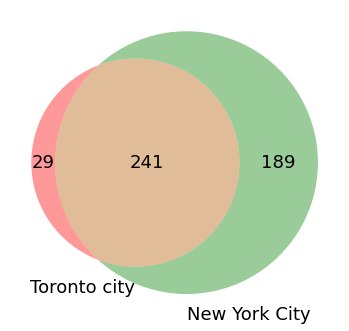

In [27]:
plt.figure(figsize = (6,6))
out = venn2(subsets = (set_toronto_venues,set_ny_venues), set_labels = ['Toronto city', 'New York City'])
for text in out.set_labels:
    text.set_fontsize(18)
for text in out.subset_labels:
    text.set_fontsize(18)
plt.show()

In [28]:
toronto_clean= toronto_venues[toronto_venues["Venue Category"].isin(set_common_venues)]
ny_clean= ny_venues[ny_venues["Venue Category"].isin(set_common_venues)]

print("Total venues in Toronto now: {0}".format(toronto_clean.shape[0]))
print("Total venues in New York City now: {0}".format(ny_clean.shape[0]))

Total venues in Toronto now: 4112
Total venues in New York City now: 9210


<div id="analyze_ny">
    <h3>a. Analyze the Manhattan neighborhood</h3>
</div>
let's group rows by neighborhood and by taking the sum of of occurrence of each category

In [29]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_clean[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_clean['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]
ny_grouped = ny_onehot.groupby('Neighborhood').sum().reset_index()
ny_grouped.head()
#merge the data with latitude longitiude of neighborhood and borough and zip code
ny_merged =ny_df.join(ny_grouped.set_index('Neighborhood'), on='Neighborhood')
ny_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Bronx,Wakefield,40.894705,-73.847201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0

lets group rows by negiborhood and by taking the maximum value of the occurance of each category, this will be used to determine the maximum number matching of venue categories

In [30]:
ny_grouped_bit = ny_onehot.groupby('Neighborhood').max().reset_index()
ny_grouped_bit.head()
#merge the data with latitude longitiude of neighborhood and borough and zip code
ny_merged_bit =ny_df.join(ny_grouped_bit.set_index('Neighborhood'), on='Neighborhood')
ny_merged_bit.head()

,Borough,Neighborhood,Latitude,Longitude,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Bronx,Wakefield,40.894705,-73.847201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0

Lets create dataframe with sum of the occurances of the venue categories

<div id="analyze_toronto">
    <h3>b. Analyze the Toronto neighborhood</h3>
</div>
let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_clean[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_clean['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped.head()
#merge the data with latitude longitiude of neighborhood and borough and zip code
toronto_merged =toronto_df.join(toronto_grouped.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [32]:
toronto_grouped_bit = toronto_onehot.groupby('Neighborhood').max().reset_index()
toronto_grouped_bit.head()
#merge the data with latitude longitiude of neighborhood and borough and zip code
toronto_merged_bit =toronto_df.join(toronto_grouped_bit.set_index('Neighborhood'), on='Neighborhood')
toronto_merged_bit.head(5)

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

<div id="similar_neighborhood">
    <h2>Finding similar neighborhood</h2>
</div>

>Let's take an example of a place where a person currently resides in Downtown Toronto Regent Park and find a similar neighborhood in New York by cosine similarity

There are few ways to find out similar neighborhoods
1. Euclidean distance or Cosine Similarity
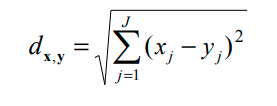
    This approach is used to calculate distance between vectors represented by 1d array. 
2. Matrix Multiplication
    <div>This appoach will be used to amplify similar venue categories and discard dissimilar venue categories when comparing 2 neighborhoods</div>

For our problem we need to find NY neighborhoods with maximum maching categories with given neighborhood in Toronto and discard dissimilar venue categories

In [33]:
# declare the index, latitude, longitude of the location we want to find the similarity in New York
t_index = toronto_merged.loc[(toronto_merged['Borough'] == 'Downtown Toronto') 
                & (toronto_merged['Neighborhood'] == 'Harbourfront')].index.values.astype(int)[0]
t_lat = toronto_merged.loc[t_index]['Latitude']
t_lon = toronto_merged.loc[t_index]['Longitude']
print('Toronto Index    :{}\nLatitude : {}\nLongitude: {}'.format(t_index, t_lat, t_lon))

Toronto Index    :3
Latitude : 43.6542599
Longitude: -79.3606359


<div id="matrix_multiplication">
    <h3>Matrix Multiplication</h3>
</div>

Steps to get matching locations
1. isolate columns from dataframes to get common venue categories columns
2. multiply given index of toronto with transpose of ny data values
3. sort the dot product of matrices to get most matched 
4. save the matching locations into a dataframe

In [34]:
#isolate common columns to form a matrix
ny_data = ny_merged_bit.iloc[:,4:]
toronto_data = toronto_merged_bit.iloc[:,5:]

#get top 5 similar neighborhoods matched for the location
n_most_similar = 5

# store only the values of the dataframes
ny_values = ny_data.values
toronto_values = toronto_data.values

# convert all NaN values to 0 in both dataframes
where_are_NaNs = np.isnan(ny_values)
ny_values[where_are_NaNs] = 0

where_are_NaNs = np.isnan(toronto_values)
toronto_values[where_are_NaNs] = 0

In [35]:
## find NY locations matching to given toronto location

matrix_multiplication_array = np.matmul(toronto_values[t_index], ny_values.T)
#return the index in sorted order (descending)of values, 
#first element correspond to the index of maximum value in a
matches_sorted = np.argsort(-matrix_multiplication_array)[0:n_most_similar] 


#retrieve and store matching locations into a dataframe
matching_locations = ny_merged.iloc[matches_sorted, :]
print(matching_locations.shape)
matching_locations.head()


(5, 244)


,Borough,Neighborhood,Latitude,Longitude,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
115,Manhattan,Murray Hill,40.748303,-73.978332,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0

<div id="validate_matched">
    <h3>Validate Matched Locations</h3>
</div>
Inorder to verify the matched locations, retrieve the 5 top common locations of the matched neighborhoods and see if it matches with given location from Toronto.

We are going to write function to display the top 5 locations of toronto and ny locations

In [36]:
def print_top_5_venues_in_toronto_neighborhood(hood, num_top_venues=5):
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [37]:
def print_top_5_venues_in_ny_neighborhood(hood, num_top_venues=5):
    print("----"+hood+"----")
    temp = ny_grouped[ny_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

Given location is in Downtown Toronto, Regent Park

In [38]:
print_top_5_venues_in_toronto_neighborhood(toronto_merged.iloc[t_index]["Neighborhood"])
for hood in matching_locations['Neighborhood']:
    print_top_5_venues_in_ny_neighborhood(hood)

----Harbourfront----
         venue  freq
0  Coffee Shop   8.0
1       Bakery   3.0
2          Pub   3.0
3         Park   3.0
4         Café   2.0


----Murray Hill----
                 venue  freq
0    Korean Restaurant  23.0
1          Coffee Shop   8.0
2                  Bar   7.0
3       Sandwich Place   6.0
4  Japanese Restaurant   4.0


----Murray Hill----
                 venue  freq
0    Korean Restaurant  23.0
1          Coffee Shop   8.0
2                  Bar   7.0
3       Sandwich Place   6.0
4  Japanese Restaurant   4.0


----Boerum Hill----
               venue  freq
0        Coffee Shop   6.0
1       Dance Studio   5.0
2                Bar   4.0
3             Bakery   3.0
4  French Restaurant   3.0


----Flatiron----
                  venue  freq
0  Gym / Fitness Center   5.0
1    Italian Restaurant   5.0
2   American Restaurant   4.0
3   Japanese Restaurant   4.0
4                   Spa   4.0


----Sutton Place----
                venue  freq
0  Italian Restaurant   6.0

Top 5 matching locations from New York are below, and their top 5 common venues for each of them

### Analyze matched locations
Let's analyze the matched neighborhoods by each venue category to the given Toronto city. The person who is moving from Toronto to New York might have priority of venue categories and this analysis below can help determine best matching city in New York.

1.  Get all venues in Toronto
2.  get missing venues in each match location in New York
3.  create a bar chart of toronto and each city

In [47]:
if('Neighborhood' in fixed_columns):
    fixed_columns.remove('Neighborhood')
    print('removed')

In [50]:
location = toronto_merged.iloc[t_index]["Neighborhood"]+ ', '+toronto_merged.iloc[t_index]["Borough"]


df1 = toronto_merged[fixed_columns].iloc[[t_index]].T
df1.index = df1.index.set_names('Venue Category')
df1.columns = [location]
df1 = df1.reset_index()
df1 = df1.loc[df1[location] > 0].sort_values(by = location, ascending = False )
df1

,Venue Category,"Harbourfront, Downtown Toronto"
54,Coffee Shop,8.0
14,Bakery,3.0
182,Pub,3.0
173,Park,3.0
225,Theater,2.0
31,Breakfast Spot,2.0
43,Café,2.0
0,Yoga Studio,1.0
115,Gym / Fitness Center,1.0
207,Spa,1.0


In [51]:
venues_to_match = df1['Venue Category'].values
df2 = matching_locations[venues_to_match].T
d = []
for i in df2.columns.values:
    d.append((i,','.join(df2[i].loc[df2[i] == 0].index.values)))


missing_venues = pd.DataFrame(d, columns=('i', 'missing_venues'))
missing_venues.set_index('i', inplace = True)
missing_venues


,missing_venues
i,
115,"Park,Performing Arts Venue,Mexican Restaurant,..."
180,"Park,Performing Arts Venue,Mexican Restaurant,..."
87,"Pub,Breakfast Spot,Shoe Store,Restaurant,Hotel..."
276,"Pub,Theater,Breakfast Spot,Shoe Store,Restaura..."
271,"Theater,Breakfast Spot,Café,Shoe Store,Perform..."


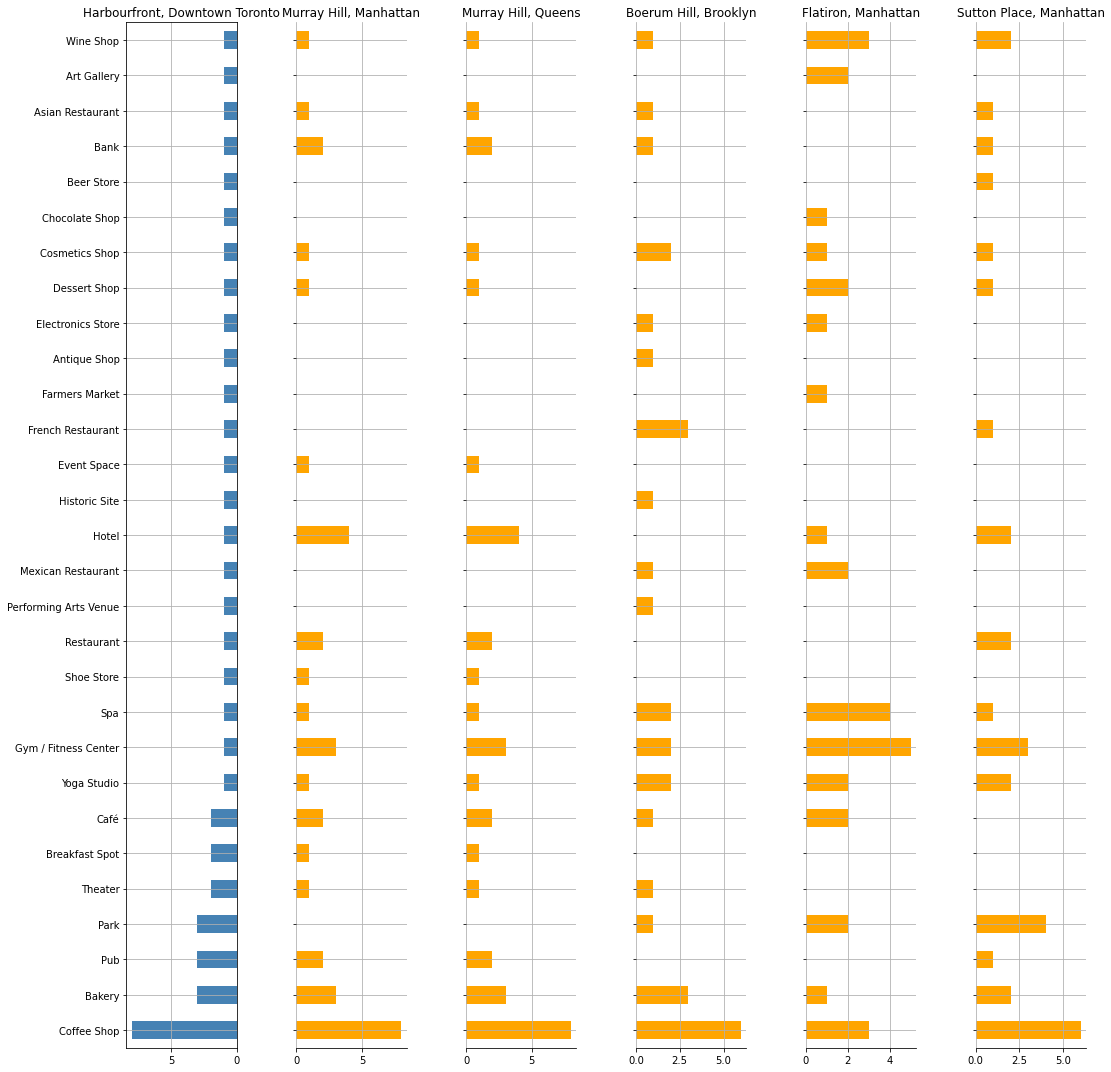

In [55]:

location = toronto_merged.iloc[t_index]["Neighborhood"]+ ', '+toronto_merged.iloc[t_index]["Borough"]

fig = plt.figure()

plot_number = 2

ax1 = fig.add_subplot(181) 
df1.plot(kind='barh',figsize=(20, 15),x = 'Venue Category',  color = 'steelblue',  ax=ax1, legend=False)
ax1.invert_xaxis()
ax1.grid(True)
ax1.set_ylabel('')
ax1.set_title(location)

for col in df2.columns.values:
    dftemp = df2[[col]]
    my_title = ny_merged.iloc[col]["Neighborhood"]+ ', '+ny_merged.iloc[col]["Borough"]
    ax = plt.subplot(1, 8, plot_number,  sharey = ax1)
    dftemp.plot(kind='barh',figsize=(20, 15),color = 'orange', ax = ax, legend=False, clip_on=False)
    ax.grid(True)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(my_title)
    plot_number = plot_number + 1

plt.tight_layout()

In [56]:
print("Missing Venue categories")
print(' ')
for borough, neighborhood, i in zip(matching_locations['Borough'],matching_locations['Neighborhood'],matching_locations.index):
    print(borough + ','+ neighborhood + ' - '+str(missing_venues.loc[i]['missing_venues']) )
    print(' ')

Missing Venue categories
 
Manhattan,Murray Hill - Park,Performing Arts Venue,Mexican Restaurant,Historic Site,French Restaurant,Farmers Market,Antique Shop,Electronics Store,Chocolate Shop,Beer Store,Art Gallery
 
Queens,Murray Hill - Park,Performing Arts Venue,Mexican Restaurant,Historic Site,French Restaurant,Farmers Market,Antique Shop,Electronics Store,Chocolate Shop,Beer Store,Art Gallery
 
Brooklyn,Boerum Hill - Pub,Breakfast Spot,Shoe Store,Restaurant,Hotel,Event Space,Farmers Market,Dessert Shop,Chocolate Shop,Beer Store,Art Gallery
 
Manhattan,Flatiron - Pub,Theater,Breakfast Spot,Shoe Store,Restaurant,Performing Arts Venue,Historic Site,Event Space,French Restaurant,Antique Shop,Beer Store,Bank,Asian Restaurant
 
Manhattan,Sutton Place - Theater,Breakfast Spot,Café,Shoe Store,Performing Arts Venue,Mexican Restaurant,Historic Site,Event Space,Farmers Market,Antique Shop,Electronics Store,Chocolate Shop,Art Gallery
 


<div id="map the matching locations">
    <h3>Mapping the matched locations</h3>
</div>

Lets map these NY neighborhoods using folium

In [57]:
import matplotlib.cm as cm
import matplotlib.colors as colors


# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11)

# set color scheme for the neighborhoods
x = np.arange(n_most_similar)

rainbow = ['red','green','blue','magenta','cyan','darkvoilet','lime']


# add markers to the map
markers_colors = []
for lat, lon, poi, matching_neighborhood in zip(matching_locations['Latitude'], matching_locations['Longitude'], matching_locations['Neighborhood'], x):
    label = folium.Popup(str(poi) + ' Neighborhood ' + str(matching_neighborhood), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[matching_neighborhood-1],
        fill=True,
        fill_color=rainbow[matching_neighborhood-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [58]:
print(x)
for lat, lon, poi, matching_neighborhood in zip(matching_locations['Latitude'], matching_locations['Longitude'], matching_locations['Neighborhood'], x):
    print(lat, lon,poi, matching_neighborhood )

[0 1 2 3 4]
40.748303077252174 -73.97833207924127 Murray Hill 0
40.764126122614066 -73.81276269135866 Murray Hill 1
40.685682912091444 -73.98374824115798 Boerum Hill 2
40.739673047638426 -73.9909471052826 Flatiron 3
40.76028033131374 -73.96355614094303 Sutton Place 4


### Combine all the above steps into a function call

In [65]:
def drawMap(map_lat,map_lon,n_most_similar,matching_locations):
    map_clusters = folium.Map(location=[map_lat, map_lon], zoom_start=11)


    # set color scheme for the neighborhoods
    x = np.arange(1,n_most_similar+1)

    rainbow = ['red','green','blue','magenta','cyan','darkvoilet','lime']


    # add markers to the map
    markers_colors = []
    for i_lat, i_lon, matching_neighborhood, poi in zip(matching_locations['Latitude'], matching_locations['Longitude'], matching_locations['Neighborhood'], x):
        label = folium.Popup(str(poi+1) + ' Neighborhood ' + str(matching_neighborhood), parse_html=True)
        folium.CircleMarker(
            [i_lat, i_lon],
            radius=5,
            popup=label,
            color=rainbow[poi+1],
            fill=True,
            fill_color=rainbow[poi+1],
            fill_opacity=0.7).add_to(map_clusters)
       
    return map_clusters



def most_similar_borough(current_city, current_borough, current_neigh, n_most_similar):
    
    
    ######### find matched locations #############
    
    
    #isolate common columns to form a matrix
    ny_data = ny_merged_bit.iloc[:,4:]
    toronto_data = toronto_merged_bit.iloc[:,5:]
    
    if current_city.lower() == 'New York'.lower():
        curr = ny_data.values
        find = toronto_data.values
        index = ny_merged_bit.loc[(ny_merged_bit['Borough'] == current_borough) 
                        & (ny_merged_bit['Neighborhood'] == current_neigh)].index.values.astype(int)[0]
        lat = ny_merged_bit.loc[index]['Latitude']
        lon = ny_merged_bit.loc[index]['Longitude']
    else:
        curr = toronto_data.values
        find = ny_data.values
        index = toronto_merged_bit.loc[(toronto_merged_bit['Borough'] == current_borough) 
                & (toronto_merged_bit['Neighborhood'] == current_neigh)].index.values.astype(int)[0]
        lat = toronto_merged_bit.loc[index]['Latitude']
        lon = toronto_merged_bit.loc[index]['Longitude']
    matrix_multiplication_array = np.matmul(curr[index], find.T)
    #return the index in sorted order (descending)of values, 
    #first element correspond to the index of maximum value in a
    matches_sorted = np.argsort(-matrix_multiplication_array)[0:n_most_similar] 

    #retrieve and store matching locations into a dataframe
    if current_city.lower() == 'New York'.lower():
        matching_locations = toronto_merged.iloc[matches_sorted, :]

    else:
        matching_locations = ny_merged.iloc[matches_sorted, :]


    

    ######## Analysis of matched locations ##########       
    
    if current_city.lower() == 'New York'.lower():
        df1 = ny_merged[fixed_columns].iloc[[index]].T
    else:
        df1 = toronto_merged[fixed_columns].iloc[[index]].T
        
    df1.index = df1.index.set_names('Venue Category')
    df1.columns = [current_neigh+', '+current_borough]
    df1 = df1.reset_index()
    df1 = df1.loc[df1[current_neigh+', '+current_borough] > 0].sort_values(by = current_neigh+', '+current_borough, ascending = False )

    venues_to_match = df1['Venue Category'].values
    df2 = matching_locations[venues_to_match].T
    d = []
    for i in df2.columns.values:
        d.append((i,','.join(df2[i].loc[df2[i] == 0].index.values)))


    missing_venues = pd.DataFrame(d, columns=('i', 'missing_venues'))
    missing_venues.set_index('i', inplace = True)
    
    ######### Plot matching venues in bar graph #########
    
    fig = plt.figure()

    plot_number = 2

    ax1 = fig.add_subplot(1,n_most_similar+1,1) 
    df1.plot(kind='barh',figsize=(20, 15),x = 'Venue Category',  color = 'steelblue',  ax=ax1, legend=False)
    ax1.invert_xaxis()
    ax1.grid(True)
    ax1.set_ylabel('')
    ax1.set_title(current_neigh+', '+current_borough)

    for col in df2.columns.values:
        dftemp = df2[[col]]
        my_title = matching_locations.loc[col]['Neighborhood']+ ','+ matching_locations.loc[col]['Borough']
        ax = plt.subplot(1, n_most_similar+1, plot_number,  sharey = ax1)
        dftemp.plot(kind='barh',figsize=(20, 15),color = 'orange', ax = ax, legend=False, clip_on=False)
        ax.grid(True)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(my_title)
        plot_number = plot_number + 1

    plt.tight_layout()

    ######### Summarize missing venues ###########
    #print("Missing Venue categories")
    #print(' ')
    #for borough, neighborhood, i in zip(matching_locations['Borough'],matching_locations['Neighborhood'],matching_locations.index):
    #    print(borough + ','+ neighborhood + ' - '+str(missing_venues.loc[i]['missing_venues']) )
    #    print(' ')
        
    ######### Map the locations ###############
    
    # create map
    if current_city.lower() == 'Toronto'.lower():
        map_lat = ny_merged_bit.loc[index]['Latitude']
        map_lon = ny_merged_bit.loc[index]['Longitude']
    else:
        map_lat = toronto_merged_bit.loc[index]['Latitude']
        map_lon = toronto_merged_bit.loc[index]['Longitude']
        
    return drawMap(map_lat,map_lon,n_most_similar,matching_locations)

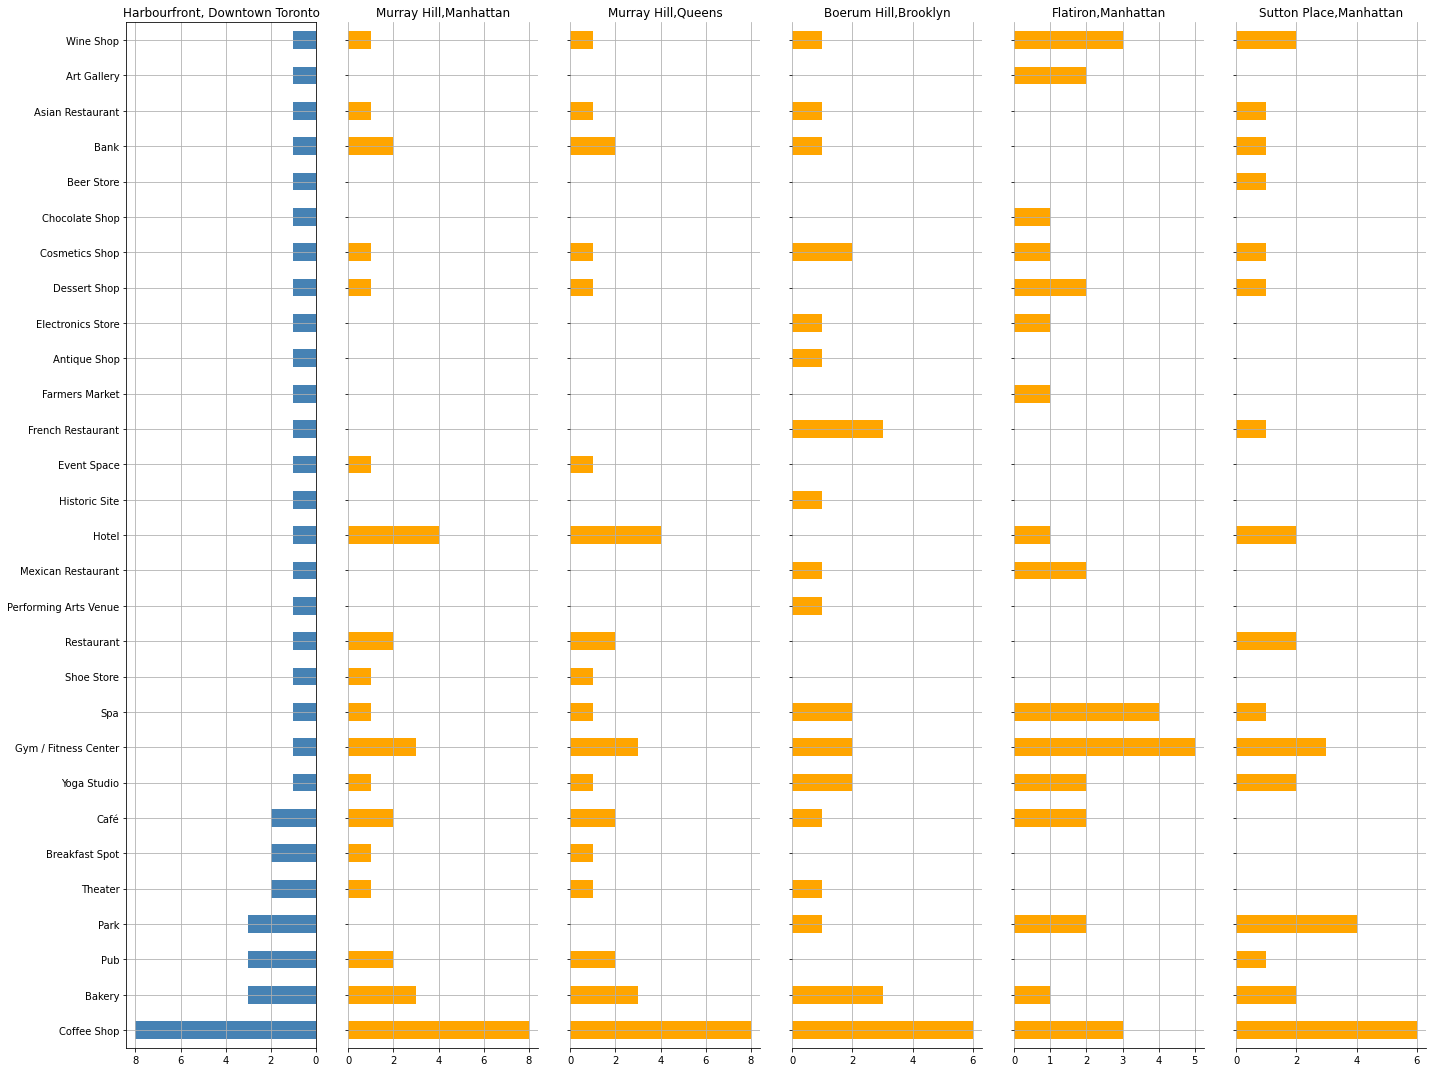

In [66]:
most_similar_borough('Toronto','Downtown Toronto','Harbourfront',5)